In [1]:
import os
import sys
import gc
import json
import shutil
import warnings
from pathlib import Path
from typing import List, Tuple, Dict, Optional

import numpy as np
import polars as pl
import pandas as pd
import pydicom
import cv2
from scipy import ndimage

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast
import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import kaggle_evaluation.rsna_inference_server

warnings.filterwarnings('ignore')

# ===================================================
# DICOM Preprocessing
# ===================================================

class DICOMPreprocessorKaggle:
    """
    DICOM preprocessing system for Kaggle Code Competition.
    Converts original DICOMPreprocessor logic to single series processing.
    """
    
    def __init__(self, target_shape: Tuple[int, int, int] = (32, 384, 384)):
        self.target_depth, self.target_height, self.target_width = target_shape
        
    def load_dicom_series(self, series_path: str) -> Tuple[List[pydicom.Dataset], str]:
        """Load DICOM series"""
        series_path = Path(series_path)
        series_name = series_path.name
        
        dicom_files = []
        for root, _, files in os.walk(series_path):
            for file in files:
                if file.endswith('.dcm'):
                    dicom_files.append(os.path.join(root, file))
        
        if not dicom_files:
            raise ValueError(f"No DICOM files found in {series_path}")
        
        datasets = []
        for filepath in dicom_files:
            try:
                ds = pydicom.dcmread(filepath, force=True)
                datasets.append(ds)
            except Exception as e:
                continue
        
        if not datasets:
            raise ValueError(f"No valid DICOM files in {series_path}")
        
        return datasets, series_name
    
    def extract_slice_info(self, datasets: List[pydicom.Dataset]) -> List[Dict]:
        """Extract position information for each slice"""
        slice_info = []
        for i, ds in enumerate(datasets):
            info = {
                'dataset': ds,
                'index': i,
                'instance_number': getattr(ds, 'InstanceNumber', i),
            }
            try:
                position = getattr(ds, 'ImagePositionPatient', None)
                if position is not None and len(position) >= 3:
                    info['z_position'] = float(position[2])
                else:
                    info['z_position'] = float(info['instance_number'])
            except Exception as e:
                info['z_position'] = float(i)
            
            slice_info.append(info)
        
        return slice_info
    
    def sort_slices_by_position(self, slice_info: List[Dict]) -> List[Dict]:
        """Sort slices by z-coordinate"""
        return sorted(slice_info, key=lambda x: x['z_position'])
    
    def get_windowing_params(self, ds: pydicom.Dataset, img: np.ndarray = None) -> Tuple[Optional[float], Optional[float]]:
        """Get windowing parameters based on modality"""
        modality = getattr(ds, 'Modality', 'CT')
        if modality == 'CT':
            return "CT", "CT"
        elif modality == 'MR':
            return None, None
        else:
            return None, None
    
    def apply_windowing_or_normalize(self, img: np.ndarray, center: Optional[float], width: Optional[float]) -> np.ndarray:
        """Apply windowing or statistical normalization"""
        if center is not None and width is not None:
            # Statistical normalization for CT
            p1, p99 = 0, 500
            if p99 > p1:
                normalized = np.clip(img, p1, p99)
                normalized = (normalized - p1) / (p99 - p1)
                result = (normalized * 255).astype(np.uint8)
                return result
            else:
                # Fallback: min-max normalization
                img_min, img_max = img.min(), img.max()
                if img_max > img_min:
                    normalized = (img - img_min) / (img_max - img_min)
                    return (normalized * 255).astype(np.uint8)
                else:
                    return np.zeros_like(img, dtype=np.uint8)
        else:
            # Statistical normalization for MR (1-99 percentile)
            p1, p99 = np.percentile(img, [1, 99])
            if p99 > p1:
                normalized = np.clip(img, p1, p99)
                normalized = (normalized - p1) / (p99 - p1)
                return (normalized * 255).astype(np.uint8)
            else:
                # Fallback: min-max normalization
                img_min, img_max = img.min(), img.max()
                if img_max > img_min:
                    normalized = (img - img_min) / (img_max - img_min)
                    return (normalized * 255).astype(np.uint8)
                else:
                    return np.zeros_like(img, dtype=np.uint8)
    
    def extract_pixel_array(self, ds: pydicom.Dataset) -> np.ndarray:
        """Extract 2D pixel array from DICOM and apply basic preprocessing"""
        img = ds.pixel_array.astype(np.float32)
        
        if img.ndim == 3: # Use middle frame for multi-frame DICOMs
            frame_idx = img.shape[0] // 2
            img = img[frame_idx]
        
        if img.ndim == 3 and img.shape[-1] == 3: # Convert color to grayscale
            img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32)
        
        # RescaleSlope and RescaleIntercept are hardcoded to 1 and 0
        slope, intercept = 1, 0
        if slope != 1 or intercept != 0:
            img = img * float(slope) + float(intercept)
        
        return img
    
    def resize_volume_3d(self, volume: np.ndarray) -> np.ndarray:
        """Resize 3D volume to target size using linear interpolation"""
        current_shape = volume.shape
        target_shape = (self.target_depth, self.target_height, self.target_width)
        
        if current_shape == target_shape:
            return volume
        
        zoom_factors = [target_shape[i] / current_shape[i] for i in range(3)]
        resized_volume = ndimage.zoom(volume, zoom_factors, order=1, mode='nearest')
        
        # Clip to exact size
        resized_volume = resized_volume[:self.target_depth, :self.target_height, :self.target_width]
        
        # Pad if necessary
        pad_width = [
            (0, max(0, self.target_depth - resized_volume.shape[0])),
            (0, max(0, self.target_height - resized_volume.shape[1])),
            (0, max(0, self.target_width - resized_volume.shape[2]))
        ]
        
        if any(pw[1] > 0 for pw in pad_width):
            resized_volume = np.pad(resized_volume, pad_width, mode='edge')
        
        return resized_volume.astype(np.uint8)
    
    def process_series(self, series_path: str) -> np.ndarray:
        """Process a full DICOM series and return a NumPy array"""
        try:
            datasets, series_name = self.load_dicom_series(series_path)
            first_ds = datasets[0]
            first_img = first_ds.pixel_array
            
            if len(datasets) == 1 and first_img.ndim == 3:
                return self._process_single_3d_dicom(first_ds, series_name)
            else:
                return self._process_multiple_2d_dicoms(datasets, series_name)
        except Exception as e:
            raise
    
    def _process_single_3d_dicom(self, ds: pydicom.Dataset, series_name: str) -> np.ndarray:
        """Process a single 3D DICOM file"""
        volume = ds.pixel_array.astype(np.float32)
        
        slope, intercept = 1, 0 # Hardcoded
        if slope != 1 or intercept != 0:
            volume = volume * float(slope) + float(intercept)
        
        window_center, window_width = self.get_windowing_params(ds)
        
        processed_slices = []
        for i in range(volume.shape[0]):
            slice_img = volume[i]
            processed_img = self.apply_windowing_or_normalize(slice_img, window_center, window_width)
            processed_slices.append(processed_img)
        
        volume = np.stack(processed_slices, axis=0)
        return self.resize_volume_3d(volume)
    
    def _process_multiple_2d_dicoms(self, datasets: List[pydicom.Dataset], series_name: str) -> np.ndarray:
        """Process a series of multiple 2D DICOM files"""
        slice_info = self.extract_slice_info(datasets)
        sorted_slices = self.sort_slices_by_position(slice_info)
        
        first_img = self.extract_pixel_array(sorted_slices[0]['dataset'])
        window_center, window_width = self.get_windowing_params(sorted_slices[0]['dataset'], first_img)
        
        processed_slices = []
        for slice_data in sorted_slices:
            ds = slice_data['dataset']
            img = self.extract_pixel_array(ds)
            processed_img = self.apply_windowing_or_normalize(img, window_center, window_width)
            resized_img = cv2.resize(processed_img, (self.target_width, self.target_height))
            processed_slices.append(resized_img)

        volume = np.stack(processed_slices, axis=0)
        return self.resize_volume_3d(volume)

def process_dicom_series_safe(series_path: str, target_shape: Tuple[int, int, int] = (32, 384, 384)) -> np.ndarray:
    """Safe DICOM processing wrapper with memory cleanup"""
    try:
        preprocessor = DICOMPreprocessorKaggle(target_shape=target_shape)
        volume = preprocessor.process_series(series_path)
        return volume
    finally:
        gc.collect()

# ===================================================
# Configuration
# ===================================================
class InferenceConfig:
    # Model settings
    model_name = "tf_efficientnetv2_s.in21k_ft_in1k"
    size = 384
    num_classes = 14
    in_chans = 32
    
    # Preprocessing settings
    target_shape = (32, 384, 384)  # (depth, height, width)
    
    # Inference settings
    batch_size = 1
    use_amp = True
    
    # Model paths and ensemble settings
    model_dir = '/kaggle/input/rsna2025-effnetv2-32ch'
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    ensemble_weights = None  # None for equal weights

CFG = InferenceConfig()

# Competition constants
ID_COL = 'SeriesInstanceUID'
LABEL_COLS = [
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation',
    'Aneurysm Present',
]

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ===================================================
# Globals for Model and Transforms
# ===================================================
MODELS = {}
TRANSFORM = None

# ===================================================
# Transforms
# ===================================================
def get_inference_transform():
    """Returns the inference transformation pipeline."""
    return A.Compose([
        A.Resize(CFG.size, CFG.size),
        A.Normalize(),
        ToTensorV2(),
    ])

# ===================================================
# Model Loading
# ===================================================
def load_model_fold(fold: int) -> nn.Module:
    """Load a single model from a checkpoint file."""
    model_path = Path(CFG.model_dir) / f'{CFG.model_name}_fold{fold}_best.pth'
    if not model_path.exists():
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    model = timm.create_model(
        CFG.model_name, 
        num_classes=CFG.num_classes, 
        pretrained=False,
        in_chans=CFG.in_chans
    )
    
    model.load_state_dict(checkpoint['model'])
    model = model.to(device)
    model.eval()
    return model

def load_models():
    """Load all models for the ensemble and initialize transforms."""
    global MODELS, TRANSFORM
    for fold in CFG.trn_fold:
        try:
            MODELS[fold] = load_model_fold(fold)
        except Exception as e:
            print(f"Warning: Could not load fold {fold}: {e}")
    
    if not MODELS:
        raise ValueError("No models were loaded successfully.")
    
    TRANSFORM = get_inference_transform()
    
    # Warm up models
    dummy_image = torch.randn(1, CFG.in_chans, CFG.size, CFG.size).to(device)
    with torch.no_grad():
        for model in MODELS.values():
            _ = model(dummy_image)

# ===================================================
# Prediction Functions
# ===================================================
def predict_single_model(model: nn.Module, image: np.ndarray) -> np.ndarray:
    """Make a prediction with a single model."""
    # Transpose from (D, H, W) to (H, W, D) for Albumentations
    image = image.transpose(1, 2, 0)
    
    transformed = TRANSFORM(image=image)
    image_tensor = transformed['image'].unsqueeze(0).to(device)
    
    with torch.no_grad(), autocast(enabled=CFG.use_amp):
        output = model(image_tensor)
        return torch.sigmoid(output).cpu().numpy().squeeze()

def predict_ensemble(image: np.ndarray) -> np.ndarray:
    """Make an ensemble prediction across all loaded models."""
    all_predictions = [predict_single_model(model, image) for model in MODELS.values()]
    
    if CFG.ensemble_weights:
        weights = np.array([CFG.ensemble_weights.get(fold, 1.0) for fold in MODELS.keys()])
    else:
        weights = np.ones(len(MODELS))
        
    return np.average(np.array(all_predictions), weights=weights / weights.sum(), axis=0)

def _predict_inner(series_path: str) -> pl.DataFrame:
    """Internal prediction logic for a single series."""
    global MODELS
    if not MODELS:
        load_models()
    
    series_id = os.path.basename(series_path)
    
    try:
        volume = process_dicom_series_safe(series_path, CFG.target_shape)
        final_pred = predict_ensemble(volume)
        
        return pl.DataFrame(
            data=[final_pred.tolist()],
            schema=LABEL_COLS,
            orient='row'
        )
    except Exception as e:
        print(f"Error processing {series_id}: {e}. Returning conservative predictions.")
        conservative_preds = [0.1] * len(LABEL_COLS)
        return pl.DataFrame(
            data=[conservative_preds],
            schema=LABEL_COLS,
            orient='row'
        )

def predict(series_path: str) -> pl.DataFrame:
    """
    Top-level prediction function passed to the inference server.
    Ensures robust error handling and resource cleanup.
    """
    try:
        return _predict_inner(series_path)
    except Exception as e:
        print(f"Top-level error for {os.path.basename(series_path)}: {e}. Using fallback.")
        conservative_preds = [0.1] * len(LABEL_COLS)
        return pl.DataFrame(
            data=[conservative_preds],
            schema=LABEL_COLS,
            orient='row'
        )
    finally:
        # Cleanup to prevent disk space/memory issues in the Kaggle environment
        shared_dir = '/kaggle/shared'
        shutil.rmtree(shared_dir, ignore_errors=True)
        os.makedirs(shared_dir, exist_ok=True)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

# ===================================================
# Main Execution
# ===================================================
if __name__ == '__main__':
    # Pre-load models at startup
    load_models()

    # Initialize and run the inference server
    inference_server = kaggle_evaluation.rsna_inference_server.RSNAInferenceServer(predict)

    # Check environment and run accordingly
    if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
        inference_server.serve()
    else:
        # For local testing, run the gateway
        inference_server.run_local_gateway()
        
        # Display local submission file for verification
        if os.path.exists('/kaggle/working/submission.parquet'):
            submission_df = pl.read_parquet('/kaggle/working/submission.parquet')
            print("Local submission file created:")
            print(submission_df)

/usr/local/lib/python3.11/dist-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


Local submission file created:
shape: (3, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ SeriesIns ┆ Left Infr ┆ Right Inf ┆ Left Supr ┆ … ┆ Right     ┆ Basilar   ┆ Other     ┆ Aneurysm │
│ tanceUID  ┆ aclinoid  ┆ raclinoid ┆ aclinoid  ┆   ┆ Posterior ┆ Tip       ┆ Posterior ┆ Present  │
│ ---       ┆ Internal  ┆ Internal  ┆ Internal  ┆   ┆ Communica ┆ ---       ┆ Circulati ┆ ---      │
│ str       ┆ Car…      ┆ Ca…       ┆ Car…      ┆   ┆ ting …    ┆ f64       ┆ on        ┆ f64      │
│           ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆           ┆ ---       ┆          │
│           ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆           ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1.2.826.0 ┆ 0.011693  ┆ 0.02094   ┆ 0.045026  ┆ … ┆ 0.017929  ┆ 0.034808  ┆ 0.028427  ┆ 0.369604 │
│ .1.368004 ┆           ┆           ┆        

In [2]:
import nibabel as nib

In [3]:
path="/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations/1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381.nii"

In [4]:
img = nib.load(path).get_fdata()
img.shape

(512, 512, 228)

In [5]:
print(f"The .nii files are stored in memory as numpy's: {type(img)}.")

The .nii files are stored in memory as numpy's: <class 'numpy.memmap'>.


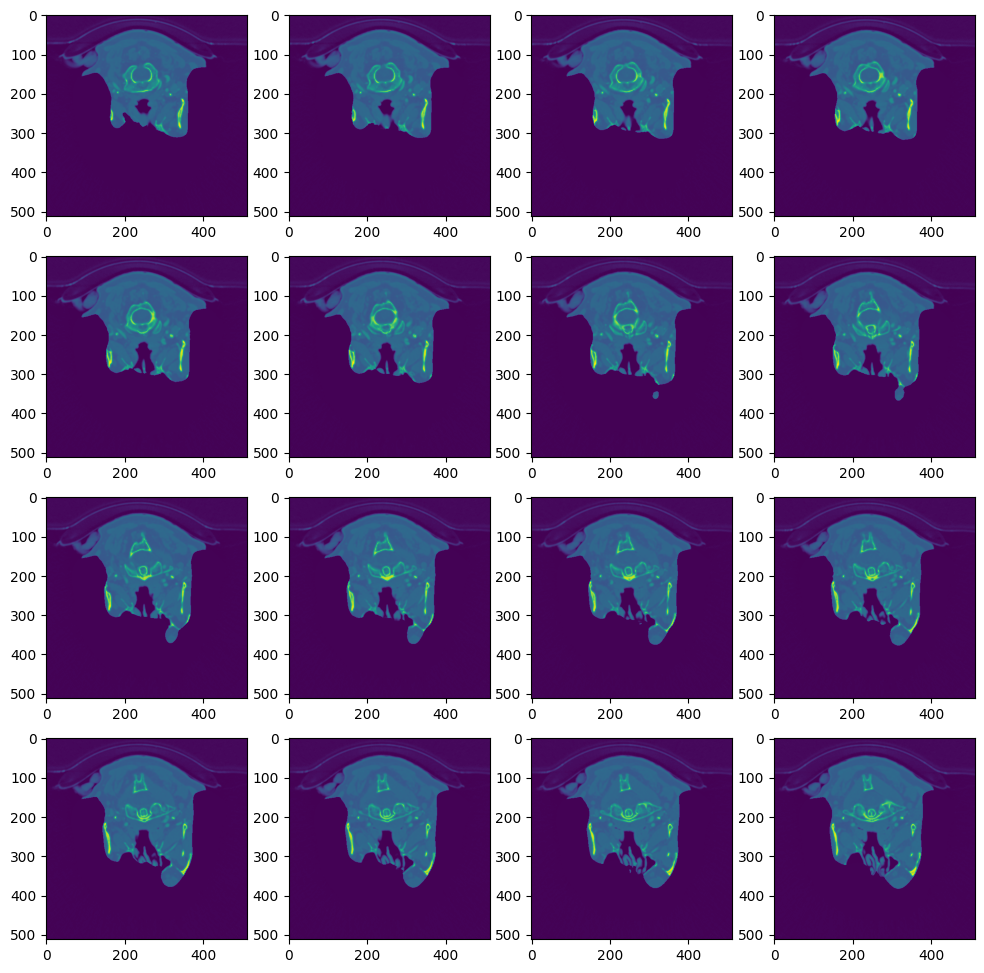

In [6]:
from skimage.transform import rotate
import matplotlib.pyplot as plt
plt.style.use('default')
fig, axes = plt.subplots(4,4, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    img_rot = rotate(img[:,:,1 + i], -90)
    ax.imshow(img_rot)
plt.show()

In [7]:
import nibabel as nib
import numpy as np

# Load the NIfTI segmentation file
nii_file = "/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations/1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381.nii"
seg_img = nib.load(nii_file)

# Get voxel data as numpy array
seg_data = seg_img.get_fdata()   # float64 array
seg_data = seg_data.astype(np.int16)  # convert to int labels

print("Shape:", seg_data.shape)   # e.g. (512, 512, 100)
print("Unique labels:", np.unique(seg_data))


Shape: (512, 512, 228)
Unique labels: [-1024 -1023 -1022 ...  2680  2686  2692]


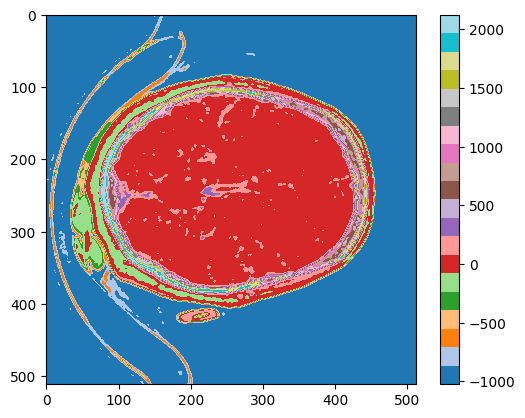

In [8]:
import matplotlib.pyplot as plt

slice_idx = seg_data.shape[2] // 2   # middle slice
plt.imshow(seg_data[:, :, slice_idx], cmap="tab20")  
plt.colorbar()
plt.show()


In [9]:
unique, counts = np.unique(seg_data, return_counts=True)
label_counts = dict(zip(unique, counts))

print("Voxel counts per label:", label_counts)


Voxel counts per label: {-1024: 1385522, -1023: 452227, -1022: 289280, -1021: 246903, -1020: 237572, -1019: 242372, -1018: 255023, -1017: 274359, -1016: 299302, -1015: 328866, -1014: 365766, -1013: 405888, -1012: 452984, -1011: 504301, -1010: 560472, -1009: 619344, -1008: 684991, -1007: 749579, -1006: 815344, -1005: 877358, -1004: 931984, -1003: 977520, -1002: 1012873, -1001: 1028197, -1000: 3883774, -999: 1010619, -998: 970479, -997: 914221, -996: 846297, -995: 766528, -994: 682457, -993: 597681, -992: 514108, -991: 440567, -990: 372626, -989: 315019, -988: 265483, -987: 225226, -986: 193021, -985: 166725, -984: 146383, -983: 130034, -982: 117973, -981: 107096, -980: 100534, -979: 94644, -978: 91183, -977: 88671, -976: 87372, -975: 87468, -974: 88993, -973: 90938, -972: 94702, -971: 99636, -970: 105658, -969: 114086, -968: 122881, -967: 133945, -966: 146676, -965: 159911, -964: 175964, -963: 192421, -962: 209621, -961: 227316, -960: 246207, -959: 263951, -958: 281316, -957: 296641, -9

In [10]:
import numpy as np

# Ensure integer labels
seg_data = seg_data.astype(np.int32)

# Get unique labels
unique, counts = np.unique(seg_data, return_counts=True)
label_counts = dict(zip(unique, counts))

print("Unique labels in mask:", label_counts.keys())


Unique labels in mask: dict_keys([-1024, -1023, -1022, -1021, -1020, -1019, -1018, -1017, -1016, -1015, -1014, -1013, -1012, -1011, -1010, -1009, -1008, -1007, -1006, -1005, -1004, -1003, -1002, -1001, -1000, -999, -998, -997, -996, -995, -994, -993, -992, -991, -990, -989, -988, -987, -986, -985, -984, -983, -982, -981, -980, -979, -978, -977, -976, -975, -974, -973, -972, -971, -970, -969, -968, -967, -966, -965, -964, -963, -962, -961, -960, -959, -958, -957, -956, -955, -954, -953, -952, -951, -950, -949, -948, -947, -946, -945, -944, -943, -942, -941, -940, -939, -938, -937, -936, -935, -934, -933, -932, -931, -930, -929, -928, -927, -926, -925, -924, -923, -922, -921, -920, -919, -918, -917, -916, -915, -914, -913, -912, -911, -910, -909, -908, -907, -906, -905, -904, -903, -902, -901, -900, -899, -898, -897, -896, -895, -894, -893, -892, -891, -890, -889, -888, -887, -886, -885, -884, -883, -882, -881, -880, -879, -878, -877, -876, -875, -874, -873, -872, -871, -870, -869, -868,

In [11]:
import nibabel as nib

nii = nib.load("/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations/1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381_cowseg.nii")
header = nii.header
affine = nii.affine
data = nii.get_fdata()


In [12]:
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512 228   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.          0.47460938  0.47460938  0.7000122   1.          1.
  1.          1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 128.2627
qoffset_y       : 111.237305
qo

In [13]:
import numpy as np
unique, counts = np.unique(data.astype(int), return_counts=True)
print(dict(zip(unique, counts)))


{0: 59742996, 1: 8142, 2: 142, 5: 5456, 6: 5624, 7: 1332, 8: 1363, 9: 1290, 10: 1433, 11: 569, 12: 476, 13: 9}
